In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ito_diffusions import *
from ou_fitting import *
from scipy.stats import laplace
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
DAYS_IN_YEAR = 252
T = 8
SCHEME_STEPS = int(DAYS_IN_YEAR*T)

In [4]:
std_dev_weight = 1.0
n_quadrature = 15

## Ornstein-Uhlenbeck with jumps

$dX_t = \lambda(\theta_0-X_t)dt + \sigma dW_t + dJ_t$ where the jump process $J_t$ has constant Poisson intensity $m$ and jump size distribution $Laplace(\gamma)$.

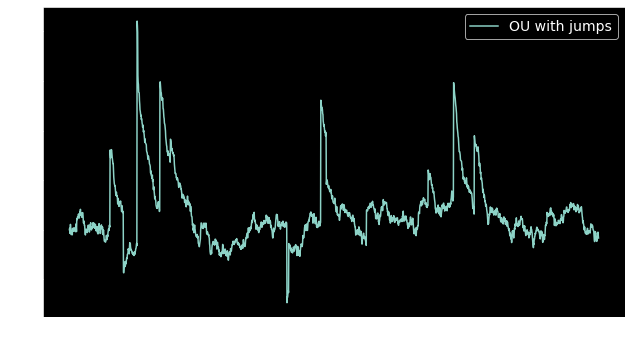

In [5]:
fig, ax = plt.subplots(figsize=(9,5), nrows=1, ncols=1)

mean_reversion = 5.0
long_term = 0.0
vol = 0.4

jump_intensity = 2.0
jump_size_scale = 1.0
jump_size_distr = laplace(loc=0.0, scale=1/jump_size_scale)

jump_params = {
    'jump_intensity_func': lambda t,x: jump_intensity,
    'jump_size_distr': jump_size_distr,
}

OU = Vasicek(x0=0.0, T=T, scheme_steps=SCHEME_STEPS, 
             vol=vol, long_term=long_term, mean_reversion=mean_reversion,
             jump_params=jump_params
            )

df = OU.simulate()

ax.plot(df, label='OU with jumps')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Estimate all parameters at once

In [6]:
fitter = OU_jump_Laplace_fitter(theta_init_mode='random',
                                std_dev_weight=std_dev_weight,
                                n_quadrature=n_quadrature,
                               )
fitter.df = df
fitter.regularization = 0.0

In [7]:
fitter.theta_init

[5.466329430348327,
 0.3984945463000147,
 0.5165577111834653,
 0.24127235803002517,
 2.5142897934822996]

In [8]:
fit_info = fitter.fit()
fit_info

      fun: 0.00034064667294193406
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.66640615e-08,  2.39144642e-06,  9.79847713e-08, -2.14731661e-07,
        6.79361081e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 234
      nit: 34
   status: 0
  success: True
        x: array([5.07058027e+00, 6.56916597e-03, 6.53314173e-04, 1.52181724e+00,
       3.48852523e+00])

In [9]:
print('Ground truth:')
print('mean reversion: {:.2f}'.format(OU.mean_reversion))
print('long term: {:.2f}'.format(OU.long_term))
print('vol: {:.2%}'.format(OU.vol_double))
print('intensity: {:.2f}'.format(jump_intensity))
print('jump size scale: {:.2f}'.format(jump_size_scale))

print('\nFitted:')
print('mean reversion: {:.2f}'.format(fitter.theta[0]))
print('long term: {:.2f}'.format(fitter.theta[1]))
print('vol: {:.0%}'.format(fitter.theta[2]))
print('intensity: {:.2f}'.format(fitter.theta[4]))
print('jump size scale: {:.2f}'.format(fitter.theta[3]))

print('\nRegression (diffusion only):')
print('mean reversion (annualized): {:.2f}'.format(fitter.theta_regression()[0]))
print('long term: {:.2f}'.format(fitter.theta_regression()[1]))
print('vol (annualized): {:.0%}'.format(fitter.vol_estimate()))

Ground truth:
mean reversion: 5.00
long term: 0.00
vol: 40.00%
intensity: 2.00
jump size scale: 1.00

Fitted:
mean reversion: 5.07
long term: 0.01
vol: 0%
intensity: 3.49
jump size scale: 1.52

Regression (diffusion only):
mean reversion (annualized): 5.02
long term: -0.02
vol (annualized): 44%


## Ornstein-Uhlenbeck with jumps, only fit jump parameters

In [10]:
fitter = OU_jump_only_Laplace_fitter(theta_init_mode='random',
                                     std_dev_weight=std_dev_weight,
                                     n_quadrature=n_quadrature,
                                    )
fitter.df = df
fitter.theta_diffusion = [mean_reversion, long_term, vol]
fitter.regularization = 0.0

In [11]:
fitter.theta_init

[0.24560053685468342, 4.4308419167970605]

In [12]:
fit_info = fitter.fit()
fit_info

      fun: 0.00042223526779906615
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.55732090e-06,  8.37291391e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 54
      nit: 17
   status: 0
  success: True
        x: array([1.4157426 , 2.85197345])

In [13]:
print('Ground truth:')
print('intensity: {:.2f}'.format(jump_intensity))
print('jump size scale: {:.2f}'.format(jump_size_scale))

print('\nFitted:')
print('intensity: {:.2f}'.format(fitter.theta[1]))
print('jump size scale: {:.2f}'.format(fitter.theta[0]))

Ground truth:
intensity: 2.00
jump size scale: 1.00

Fitted:
intensity: 2.85
jump size scale: 1.42


## Estimate all parameters except mean-reversion

In [14]:
fitter = OU_jump_Laplace_fixed_mr_fitter(theta_init_mode='random',
                                         std_dev_weight=std_dev_weight,
                                         n_quadrature=n_quadrature,
                                        )
fitter.df = df
fitter.regularization = 0.0

In [15]:
fitter.theta_init

[-0.028409880609807203,
 0.9988462902243126,
 0.2402271058784448,
 1.0516817493546646]

In [16]:
fit_info = fitter.fit()
fit_info

      fun: 0.0003406466954612009
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.97299987e-06,  9.16313466e-08, -1.49129840e-06,  4.82643439e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 190
      nit: 32
   status: 0
  success: True
        x: array([6.56643736e-03, 5.98857471e-04, 1.52185542e+00, 3.45457240e+00])

In [17]:
print('Ground truth:')
print('mean reversion: {:.2f}'.format(OU.mean_reversion))
print('long term: {:.2f}'.format(OU.long_term))
print('vol: {:.2%}'.format(OU.vol_double))
print('intensity: {:.2f}'.format(jump_intensity))
print('jump size scale: {:.2f}'.format(jump_size_scale))

print('\nFitted:')
print('mean reversion: {:.2f}'.format(fitter.theta_regression()[0]))
print('long term: {:.2f}'.format(fitter.theta[0]))
print('vol: {:.0%}'.format(fitter.theta[1]))
print('intensity: {:.2f}'.format(fitter.theta[3]))
print('jump size scale: {:.2f}'.format(fitter.theta[2]))

Ground truth:
mean reversion: 5.00
long term: 0.00
vol: 40.00%
intensity: 2.00
jump size scale: 1.00

Fitted:
mean reversion: 5.02
long term: 0.01
vol: 0%
intensity: 3.45
jump size scale: 1.52


## Estimate all parameters except vol

Compared to mean-reversion, volatility can be estimated in a robust fashion by using inter-quantile range estimate (basically fitting a normal distribution using the quantiles rather than the moments as these are less sensitive to the large deviations coming from the jumps).

In [6]:
fitter = OU_jump_Laplace_fixed_vol_fitter(theta_init_mode='random',
                                          std_dev_weight=std_dev_weight,
                                          n_quadrature=n_quadrature,
                                         )
fitter.df = df
fitter.regularization = 0.0

In [7]:
fitter.theta_init

[5.208214673451827, -0.998251394417359, 0.2146132348419567, 1.190708176659654]

In [9]:
fitter.reg_weights(10).shape

(2016, 2016)

In [12]:
np.diag(fitter.reg_weights(10))[-17:-1]

array([0.57434918, 0.59460356, 0.61557221, 0.63728031, 0.65975396,
       0.68302013, 0.70710678, 0.73204285, 0.75785828, 0.7845841 ,
       0.8122524 , 0.84089642, 0.87055056, 0.90125046, 0.93303299,
       0.96593633])

In [14]:
fit_info = fitter.fit()
fit_info

      fun: 0.0005676342321456402
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.17989689e-07,  3.71944446e-05, -4.65155258e-06,  9.72529349e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 140
      nit: 24
   status: 0
  success: True
        x: array([4.28989843, 0.15058947, 2.53450636, 2.5884067 ])

In [16]:
print('Ground truth:')
print('mean reversion: {:.2f}'.format(OU.mean_reversion))
print('long term: {:.2f}'.format(OU.long_term))
print('vol: {:.2%}'.format(OU.vol_double))
print('intensity: {:.2f}'.format(jump_intensity))
print('jump size scale: {:.2f}'.format(jump_size_scale))

print('\nFitted:')
print('mean reversion: {:.2f}'.format(fitter.theta[0]))
print('long term: {:.2f}'.format(fitter.theta[1]))
print('vol: {:.0%}'.format(fitter.vol_estimate()))
print('intensity: {:.2f}'.format(fitter.theta[3]))
print('jump size scale: {:.2f}'.format(fitter.theta[2]))

print('\nRegression (diffusion only):')
print('mean reversion (annualized): {:.2f}'.format(fitter.theta_regression()[0]))
print('long term: {:.2f}'.format(fitter.theta_regression()[1]))
print('vol (annualized): {:.0%}'.format(fitter.vol_estimate()))

Ground truth:
mean reversion: 5.00
long term: 0.00
vol: 40.00%
intensity: 2.00
jump size scale: 1.00

Fitted:
mean reversion: 4.29
long term: 0.15
vol: 41%
intensity: 2.59
jump size scale: 2.53

Regression (diffusion only):


ValueError: operands could not be broadcast together with shapes (2016,1,2016) (2016,2) 

## Calibrating a jump model when there is none...

A good test to detect potential jumps is to calibrate a jump model : if the most likely value for jump intensity is zero then the jump hypothesis can be rejected (heuristically but this can perhaps be turned into a rigorous statistical test).

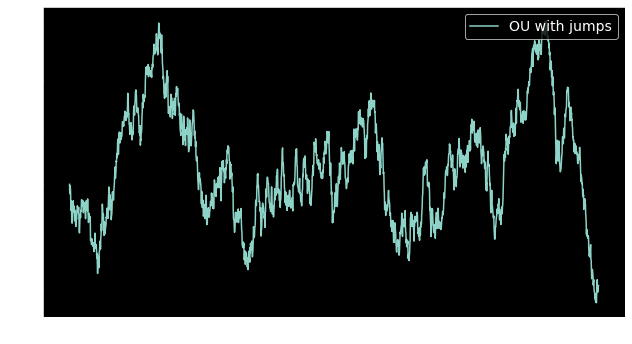

In [22]:
fig, ax = plt.subplots(figsize=(9,5), nrows=1, ncols=1)

mean_reversion = 1.0
long_term = 0.0
vol = 0.4

OU = Vasicek(x0=0.0, T=T, scheme_steps=SCHEME_STEPS, 
             vol=vol, long_term=long_term, mean_reversion=mean_reversion,
            )

df = OU.simulate()

ax.plot(df, label='OU with jumps')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [23]:
fitter = OU_jump_only_Laplace_fitter(theta_init_mode='random',
                                     std_dev_weight=std_dev_weight,
                                     n_quadrature=n_quadrature,
                                    )
fitter.df = df
fitter.theta_diffusion = [mean_reversion, long_term, vol]
fitter.regularization = 0.0

In [24]:
fitter.theta_init

[0.22936946701203864, 1.79034008702741]

In [25]:
fit_info = fitter.fit()
fit_info

      fun: 0.010955666077397355
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.        , 0.01186469])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 6
   status: 0
  success: True
        x: array([2.28694357, 0.        ])

In [26]:
print('Fitted:')
print('intensity: {:.2f}'.format(fitter.theta[1]))
print('jump size scale: {:.2f}'.format(fitter.theta[0]))

Fitted:
intensity: 0.00
jump size scale: 2.29
